In [1]:
!pip install numpy matplotlib seaborn scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pandas as pd

In [2]:
def process_all_datasets(base_path, snr_min, snr_max, window_size):
    X = []
    y = []
    for label_name in ["Berdiri", "Duduk", "Jalan", "Jatuh"]:
        label_path = os.path.join(base_path, label_name)
        if not os.path.exists(label_path):
            print(f"[WARNING] Label {label_name} tidak ditemukan, dilewati.")
            continue     
        for person_name in os.listdir(label_path):
            person_path = os.path.join(label_path, person_name)
            if not os.path.isdir(person_path):
                print(f"[WARNING] {person_name} bukan folder, dilewati.")
                continue
            # Gunakan os.walk() agar semua file terbaca
            for root, _, files in os.walk(person_path):
                for dataset_file in files:
                    if dataset_file.endswith(".csv"):
                        dataset_path = os.path.join(root, dataset_file)
                        # Tambahkan try-except agar tidak berhenti jika ada error
                        try:
                            # print(label_name)
                            # print(f"[DEBUG] Memproses file: {dataset_path}")
                            # X.append(create_heatmaps(dataset_path, f"Heatmaps-{window_size}-windowing", snr_min, snr_max, window_size))
                            # print(f"[INFO] Memproses dataset: {dataset_path}")
                            # Membaca dataset
                            df = pd.read_csv(dataset_path)
                            
                            # Pastikan kolom yang dibutuhkan ada
                            required_columns = {"timestamp", "doppler", "Range", "SNR"}
                            if not required_columns.issubset(df.columns):
                                raise ValueError(f"Dataset {dataset_path} tidak memiliki kolom yang diperlukan: {required_columns}")
                            
                            # Normalisasi SNR dengan clipping dan log transform
                            df["SNR"] = np.clip(df["SNR"], snr_min, snr_max)  # Clipping
                            df["SNR"] = np.log1p(df["SNR"])  # Log transform
                            
                            # Ambil label, person, dan nama dataset dari path
                            parts = dataset_path.split(os.sep)
                            label_name = parts[-3]
                            person_name = parts[-2]
                            dataset_name = os.path.splitext(parts[-1])[0]  # Mengambil nama file tanpa ekstensi
                            
                            # Ambil daftar timestamp unik & urutkan
                            unique_timestamps = np.sort(df["timestamp"].unique())  # Pastikan berurutan
                            
                            # print(f"[DEBUG] {dataset_path}: {len(unique_timestamps)} timestamp unik ditemukan.")
                            
                            # Proses menggunakan sliding window dengan geser 1 timestamp setiap iterasi
                            for window_idx in range(len(unique_timestamps) - window_size + 1):
                                # print(window_idx)
                                start_idx = window_idx
                                end_idx = start_idx + window_size
                                timestamps_subset = unique_timestamps[start_idx:end_idx]
                                
                                df_subset = df[df["timestamp"].isin(timestamps_subset)]
                                
                                # Pastikan ada data
                                if df_subset.empty:
                                    print(f"[WARNING] Tidak ada data setelah window {window_idx} di {dataset_path}")
                                    continue
                                
                                # Buat direktori penyimpanan jika belum ada
                                # for category in ["DopplerVsRange", "DopplerVsTime", "RangeVsTime"]:
                                #     save_path = os.path.join(save_base_path, label_name, category)
                                #     os.makedirs(save_path, exist_ok=True)
                                
                                # Parameter heatmap
                                    # Definisi bins
                                num_x, num_y, num_t = 100, 100, 100
                                x_bins = np.linspace(-7, 7, num_x)
                                y_bins = np.linspace(0, 5.385, num_y)
                                t_bins = np.linspace(df_subset["timestamp"].min(), df_subset["timestamp"].max(), num_t)
                                
                                def resize(img):
                                    img_pil = Image.fromarray(img.astype(np.uint8))
                                    img_resized = img_pil.resize((64, 64), Image.LANCZOS)
                                    img_resized = np.array(img_resized)
                                    return img_resized

                                def save_heatmap(x, y, bins_x, bins_y, category):
                                    # Buat heatmap
                                    heatmap, _, _ = np.histogram2d(x, y, bins=[bins_x, bins_y], weights=df_subset["SNR"])
                                    heatmap_counts, _, _ = np.histogram2d(x, y, bins=[bins_x, bins_y])
                                    # Hindari pembagian dengan nol
                                    heatmap_counts[heatmap_counts == 0] = 1
                                    heatmap /= heatmap_counts  # Normalisasi
                                    # stacked_output_path = os.path.join(save_base_path, label_name, category, f"{person_name}_{dataset_name}_window{window_idx}.npy")
                                    # np.save(stacked_output_path, heatmap.T)
                                    # Simpan heatmap dari masing-masing kategori
                                    return heatmap.T
                                dr = resize(save_heatmap(df_subset["doppler"], df_subset["Range"], x_bins, y_bins, "DopplerVsRange"))
                                dt = resize(save_heatmap(df_subset["timestamp"], df_subset["doppler"], t_bins, x_bins, "DopplerVsTime"))
                                rt = resize(save_heatmap(df_subset["timestamp"], df_subset["Range"], t_bins, y_bins, "RangeVsTime"))
                                heatmap_rgb = np.stack([dr, dt, rt], axis=-1)
                                heatmap_rgb = (heatmap_rgb - heatmap_rgb.min()) / (heatmap_rgb.max() - heatmap_rgb.min())
                                if label_name == "Berdiri": y.append(0)
                                elif label_name == "Duduk": y.append(1)
                                elif label_name == "Jalan": y.append(2)
                                else : y.append(3)
                                X.append(heatmap_rgb)
                                # print(X)
                                # plt.imshow(heatmap_rgb)
                                # plt.axis("off")
                                # plt.show()
                        except Exception as e:
                            print(f"[ERROR] Gagal memproses {dataset_path}: {e}")
    return np.array(X), np.array(y)

In [3]:
# Load dataset
X_files, y_files = process_all_datasets("Dataset", snr_min=4.68, snr_max=2621.36, window_size=40)
print("X shape:", X_files.shape)
print("y shape:", y_files.shape)

X shape: (12684, 64, 64, 3)
y shape: (12684,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_files, y_files, test_size=0.2, random_state=42)
# Tampilkan hasil
print("Total dataset setelah diproses:", len(X_files))
print("Train Files:", len(X_train))
print("Test Files:", len(X_test))
# Cek label unik sebelum dan setelah split
print("Label unik sebelum split:", np.unique(y_files))
print("Label unik di y_train:", np.unique(y_train))
print("Label unik di y_test:", np.unique(y_test))

Total dataset setelah diproses: 12684
Train Files: 10147
Test Files: 2537
Label unik sebelum split: [0 1 2 3]
Label unik di y_train: [0 1 2 3]
Label unik di y_test: [0 1 2 3]


In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight


# Konversi label ke one-hot encoding
# num_classes = len(labels)
# y_train_cat = to_categorical(y_train, num_classes)
# y_test_cat = to_categorical(y_test, num_classes)

# Bentuk dataset
input_shape = (64, 64, 3)
batch_size = 32  
epochs = 20  

# Hitung class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Learning Rate Schedule (Exponential Decay)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,  # Learning rate awal
    decay_steps=500,  # Setelah 500 step, learning rate berkurang
    decay_rate=0.9  # Setiap 500 step, learning rate dikalikan 0.9
)

# Optimizer dengan Learning Rate Schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Model CNN
model = Sequential([
    Conv2D(64, (3,3), padding='valid',activation='relu', input_shape=input_shape),
    MaxPooling2D((5,5)),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Compile Model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()
# Menampilkan informasi class weights
print("Class Weights yang Dihitung:")
for class_idx, weight in class_weights.items():
    print(f"Kelas {class_idx}: {weight:.4f}")



/home/jetson/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 62, 62, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 32)             │       294,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,868 (1.13 MB)

 Trainable params: 296,868 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

Class Weights yang Dihitung:
Kelas 0: 1.6198
Kelas 1: 1.3885
Kelas 2: 0.5555
Kelas 3: 1.1598


Epoch 1/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.4752 - loss: 1.0443 - val_accuracy: 0.7299 - val_loss: 0.5931
Epoch 2/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6594 - loss: 0.6400 - val_accuracy: 0.7659 - val_loss: 0.4613
Epoch 3/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7094 - loss: 0.5343 - val_accuracy: 0.8517 - val_loss: 0.3240
Epoch 4/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7527 - loss: 0.4582 - val_accuracy: 0.8617 - val_loss: 0.2829
Epoch 5/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7798 - loss: 0.4023 - val_accuracy: 0.9171 - val_loss: 0.2234
Epoch 6/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7930 - loss: 0.3777 - val_accuracy: 0.9150 - val_loss: 0.2051
Epoch 7/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8116 - loss: 0.3363 - val_accuracy: 0.9116 - val_loss: 0.2054
Epoch 8/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8257 - loss: 0.3190 - val_acc

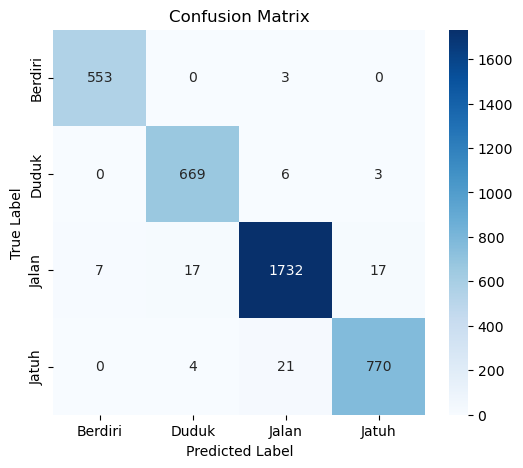

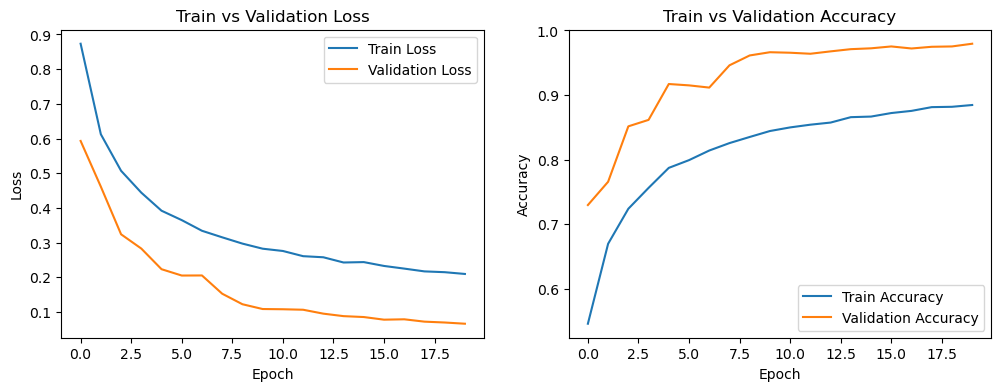

In [39]:
# Training model
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    class_weight=class_weights,
    validation_data=(X_test, y_test),
    verbose=1
)

y_pred = model.predict(X_test) 
y_pred_classes = y_pred.argmax(axis=1)  
print(classification_report(y_test, y_pred_classes))

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Berdiri','Duduk', 'Jalan', 'Jatuh'],
            yticklabels=['Berdiri','Duduk', 'Jalan', 'Jatuh'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train vs Validation Accuracy')

plt.show()

In [45]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import numpy as np

# Fungsi untuk membangun model CNN dengan 1 layer

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(
        filters=hp.Choice('filters', [16, 32, 64]),
        kernel_size=hp.Choice('kernel_size', [3,5]),
        activation='relu',
        input_shape=(64, 64, 3)
    ))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Choice('dense_units', [32, 64, 128]),
        activation='relu'
    ))
    model.add(layers.Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1)))
    model.add(layers.Dense(4, activation='softmax'))  # 4 kelas untuk HAR
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Hyperband tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='kt_tuning',
    project_name='har_tuning'
)

# Callback untuk early stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Jalankan tuning
tuner.search(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[stop_early])

# Ambil model terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Filters: {best_hps.get('filters')}")
print(f"Best Kernel Size: {best_hps.get('kernel_size')}")
print(f"Best Dense Units: {best_hps.get('dense_units')}")
print(f"Best Dropout Rate: {best_hps.get('dropout')}")
print(f"Best Learning Rate: {best_hps.get('learning_rate')}")

# Bangun model terbaik dan latih ulang
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# Evaluasi model
val_loss, val_acc = best_model.evaluate(X_test, y_test)
print(f"Best Model Validation Accuracy: {val_acc:.4f}")

Trial 30 Complete [00h 00m 56s]
val_accuracy: 0.9924392104148865

Best val_accuracy So Far: 0.9983563423156738
Total elapsed time: 00h 16m 20s
Best Filters: 64
Best Kernel Size: 5
Best Dense Units: 64
Best Dropout Rate: 0.30000000000000004
Best Learning Rate: 0.001
Epoch 1/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.7315 - loss: 0.6126 - val_accuracy: 0.9721 - val_loss: 0.0954
Epoch 2/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9612 - loss: 0.1141 - val_accuracy: 0.9895 - val_loss: 0.0382
Epoch 3/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9867 - loss: 0.0453 - val_accuracy: 0.9887 - val_loss: 0.0387
Epoch 4/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9921 - loss: 0.0286 - val_accuracy: 0.9940 - val_loss: 0.0233
Epoch 5/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9911 - loss: 0.0284 - val_accuracy: 0.9966 - val_loss: 0.0112
Epoch 6/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9955 - loss: 0.0165 -

/home/jetson/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.7125 - loss: 0.6683 - val_accuracy: 0.9508 - val_loss: 0.1547
Epoch 2/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9438 - loss: 0.1547 - val_accuracy: 0.9816 - val_loss: 0.0607
Epoch 3/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9758 - loss: 0.0710 - val_accuracy: 0.9934 - val_loss: 0.0262
Epoch 4/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9871 - loss: 0.0398 - val_accuracy: 0.9932 - val_loss: 0.0235
Epoch 5/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9896 - loss: 0.0308 - val_accuracy: 0.9958 - val_loss: 0.0139
Epoch 6/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9943 - loss: 0.0181 - val_accuracy: 0.9958 - val_loss: 0.0151
Epoch 7/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9917 - loss: 0.0224 - val_accuracy: 0.9971 - val_loss: 0.0135
Epoch 8/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9943 - loss: 0.0160 - val_acc

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,074,766 (42.25 MB)

 Trainable params: 3,691,588 (14.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,383,178 (28.16 MB)

119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step  
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       556
           1       1.00      1.00      1.00       678
           2       1.00      1.00      1.00      1773
           3       0.99      0.99      0.99       795

    accuracy                           1.00      3802
   macro avg       1.00      1.00      1.00      3802
weighted avg       1.00      1.00      1.00      3802



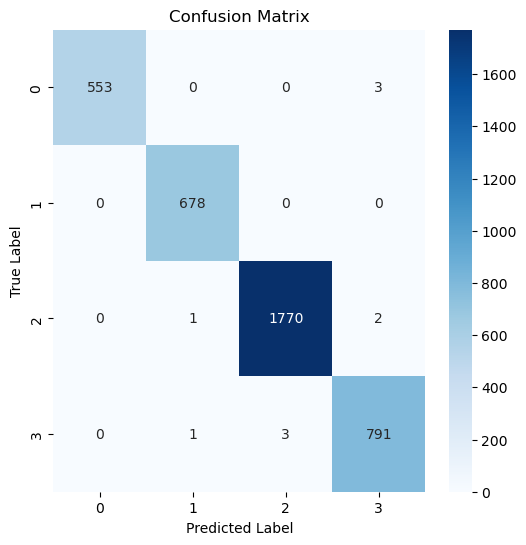

In [49]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Membangun model CNN dengan hyperparameter terbaik
best_model = keras.Sequential()
best_model.add(layers.Conv2D(
    filters=64,  # Best Filters
    kernel_size=(5,5),  # Best Kernel Size
    activation='relu',
    input_shape=(64, 64, 3)
))
best_model.add(layers.MaxPooling2D(pool_size=(2,2)))
best_model.add(layers.Flatten())
best_model.add(layers.Dense(
    units=64,  # Best Dense Units
    activation='relu'
))
best_model.add(layers.Dropout(0.3))  # Best Dropout Rate
best_model.add(layers.Dense(4, activation='softmax'))  # 4 kelas untuk HAR

# Compile model
best_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Best Learning Rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
best_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# Evaluasi model
val_loss, val_acc = best_model.evaluate(X_test, y_test)
print(f"Final Model Validation Accuracy: {val_acc:.4f}")
# Summary Model
best_model.summary()


# Prediksi
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

/home/jetson/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.7076 - loss: 0.6851 - val_accuracy: 0.9534 - val_loss: 0.1542
Epoch 2/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9408 - loss: 0.1707 - val_accuracy: 0.9779 - val_loss: 0.0769
Epoch 3/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9721 - loss: 0.0821 - val_accuracy: 0.9845 - val_loss: 0.0544
Epoch 4/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9849 - loss: 0.0500 - val_accuracy: 0.9908 - val_loss: 0.0301
Epoch 5/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9905 - loss: 0.0294 - val_accuracy: 0.9900 - val_loss: 0.0279
Epoch 6/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9939 - loss: 0.0230 - val_accuracy: 0.9945 - val_loss: 0.0167
Epoch 7/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9937 - loss: 0.0204 - val_accuracy: 0.9953 - val_loss: 0.0152
Epoch 8/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9949 - loss: 0.0171 - val_acc

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 60, 60, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │     1,638,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,930,766 (18.81 MB)

 Trainable params: 1,643,588 (6.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,287,178 (12.54 MB)

119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step   
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       556
           1       0.99      0.99      0.99       678
           2       1.00      1.00      1.00      1773
           3       0.99      1.00      0.99       795

    accuracy                           1.00      3802
   macro avg       1.00      1.00      1.00      3802
weighted avg       1.00      1.00      1.00      3802



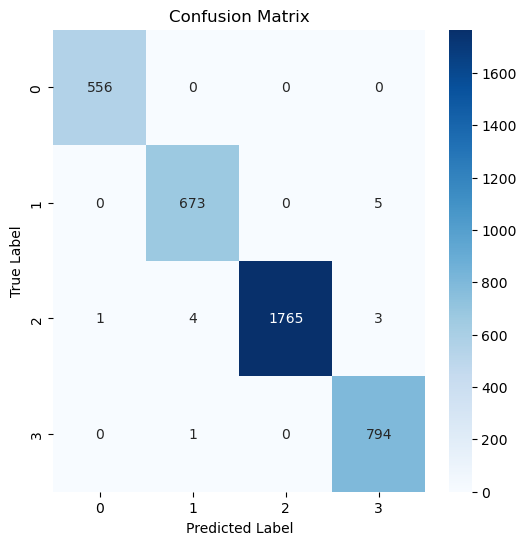

In [50]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Membangun model CNN dengan hyperparameter terbaik
best_model = keras.Sequential()
best_model.add(layers.Conv2D(
    filters=64,  # Best Filters
    kernel_size=(5,5),  # Best Kernel Size
    activation='relu',
    input_shape=(64, 64, 3)
))
best_model.add(layers.MaxPooling2D(pool_size=(3,3)))
best_model.add(layers.Flatten())
best_model.add(layers.Dense(
    units=64,  # Best Dense Units
    activation='relu'
))
best_model.add(layers.Dropout(0.3))  # Best Dropout Rate
best_model.add(layers.Dense(4, activation='softmax'))  # 4 kelas untuk HAR

# Compile model
best_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Best Learning Rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
best_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# Evaluasi model
val_loss, val_acc = best_model.evaluate(X_test, y_test)
print(f"Final Model Validation Accuracy: {val_acc:.4f}")
# Summary Model
best_model.summary()


# Prediksi
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
######################### Windowing 10

In [3]:
# Load dataset
X_files, y_files = process_all_datasets("Dataset", snr_min=4.68, snr_max=2621.36, window_size=10)
print("X shape:", X_files.shape)
print("y shape:", y_files.shape)

/tmp/ipykernel_147661/4228312786.py:95: RuntimeWarning: invalid value encountered in divide
  heatmap_rgb = (heatmap_rgb - heatmap_rgb.min()) / (heatmap_rgb.max() - heatmap_rgb.min())


X shape: (32562, 64, 64, 3)
y shape: (32562,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_files, y_files, test_size=0.2, random_state=42)
# Tampilkan hasil
print("Total dataset setelah diproses:", len(X_files))
print("Train Files:", len(X_train))
print("Test Files:", len(X_test))
# Cek label unik sebelum dan setelah split
print("Label unik sebelum split:", np.unique(y_files))
print("Label unik di y_train:", np.unique(y_train))
print("Label unik di y_test:", np.unique(y_test))

Total dataset setelah diproses: 32562
Train Files: 26049
Test Files: 6513
Label unik sebelum split: [0 1 2 3]
Label unik di y_train: [0 1 2 3]
Label unik di y_test: [0 1 2 3]


/home/jetson/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
815/815 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.5869 - loss: nan - val_accuracy: 0.2312 - val_loss: nan
Epoch 2/20
815/815 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.2365 - loss: nan - val_accuracy: 0.2312 - val_loss: nan
Epoch 3/20
815/815 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2319 - loss: nan - val_accuracy: 0.2312 - val_loss: nan
Epoch 4/20
815/815 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.2312 - loss: nan - val_accuracy: 0.2312 - val_loss: nan
Epoch 5/20
815/815 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.2315 - loss: nan - val_accuracy: 0.2312 - val_loss: nan
Epoch 6/20
815/815 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.2324 - loss: nan - val_accuracy: 0.2312 - val_loss: nan
Epoch 7/20
815/815 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2310 - loss: nan - val_accuracy: 0.2312 - val_loss: nan
Epoch 8/20
815/815 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2341 - loss: nan - val_accuracy: 0.2312 - val_loss: nan
Epoch 9/20
815/815 ━━━

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,074,766 (42.25 MB)

 Trainable params: 3,691,588 (14.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,383,178 (28.16 MB)

204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step   
Classification Report:
              precision    recall  f1-score   support

           0       0.21      1.00      0.35      1365
           1       0.00      0.00      0.00      1521
           2       0.00      0.00      0.00      2121
           3       0.00      0.00      0.00      1506

    accuracy                           0.21      6513
   macro avg       0.05      0.25      0.09      6513
weighted avg       0.04      0.21      0.07      6513



/home/jetson/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jetson/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jetson/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


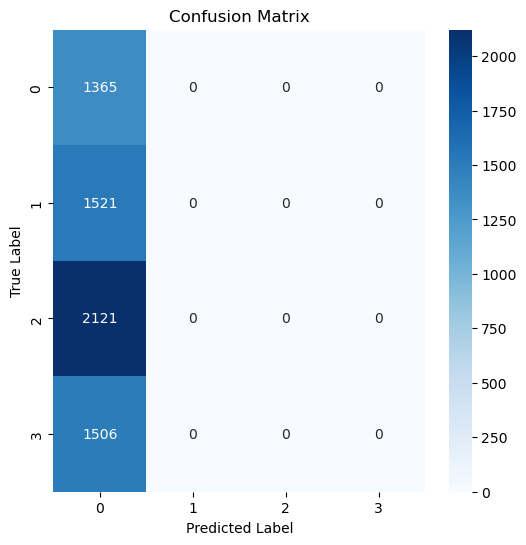

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Membangun model CNN dengan hyperparameter terbaik
best_model = keras.Sequential()
best_model.add(layers.Conv2D(
    filters=64,  # Best Filters
    kernel_size=(5,5),  # Best Kernel Size
    activation='relu',
    input_shape=(64, 64, 3)
))
best_model.add(layers.MaxPooling2D(pool_size=(2,2)))
best_model.add(layers.Flatten())
best_model.add(layers.Dense(
    units=64,  # Best Dense Units
    activation='relu'
))
best_model.add(layers.Dropout(0.3))  # Best Dropout Rate
best_model.add(layers.Dense(4, activation='softmax'))  # 4 kelas untuk HAR

# Compile model
best_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Best Learning Rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history = best_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))



# Evaluasi model
val_loss, val_acc = best_model.evaluate(X_test, y_test)
print(f"Final Model Validation Accuracy: {val_acc:.4f}")
# Summary Model
best_model.summary()


# Prediksi
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

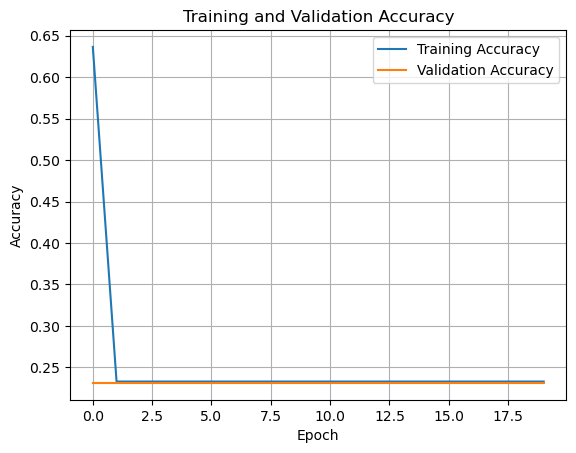

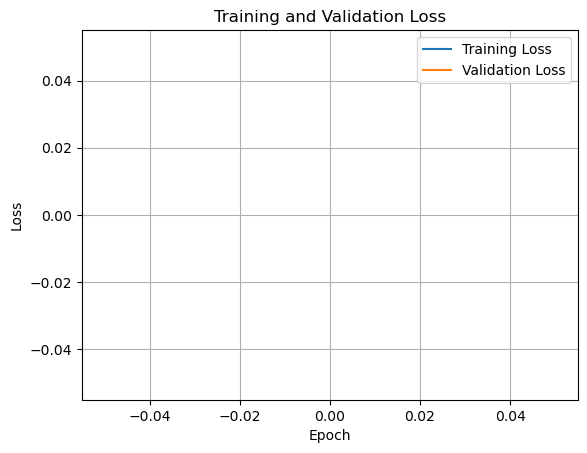

In [7]:
# Plot Akurasi
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
######################### Windowing 20

In [8]:
# Load dataset
X_files, y_files = process_all_datasets("Dataset", snr_min=4.68, snr_max=2621.36, window_size=20)
print("X shape:", X_files.shape)
print("y shape:", y_files.shape)

X shape: (25782, 64, 64, 3)
y shape: (25782,)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_files, y_files, test_size=0.2, random_state=42)
# Tampilkan hasil
print("Total dataset setelah diproses:", len(X_files))
print("Train Files:", len(X_train))
print("Test Files:", len(X_test))
# Cek label unik sebelum dan setelah split
print("Label unik sebelum split:", np.unique(y_files))
print("Label unik di y_train:", np.unique(y_train))
print("Label unik di y_test:", np.unique(y_test))

Total dataset setelah diproses: 25782
Train Files: 20625
Test Files: 5157
Label unik sebelum split: [0 1 2 3]
Label unik di y_train: [0 1 2 3]
Label unik di y_test: [0 1 2 3]


/home/jetson/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.6798 - loss: 0.7343 - val_accuracy: 0.9110 - val_loss: 0.2514
Epoch 2/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9051 - loss: 0.2522 - val_accuracy: 0.9657 - val_loss: 0.1151
Epoch 3/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9536 - loss: 0.1314 - val_accuracy: 0.9760 - val_loss: 0.0739
Epoch 4/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9766 - loss: 0.0739 - val_accuracy: 0.9707 - val_loss: 0.0741
Epoch 5/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9803 - loss: 0.0601 - val_accuracy: 0.9855 - val_loss: 0.0476
Epoch 6/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9856 - loss: 0.0419 - val_accuracy: 0.9874 - val_loss: 0.0433
Epoch 7/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9857 - loss: 0.0374 - val_accuracy: 0.9864 - val_loss: 0.0358
Epoch 8/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9897 - loss: 0.0291 - val_accuracy:

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,074,766 (42.25 MB)

 Trainable params: 3,691,588 (14.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,383,178 (28.16 MB)

162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step   
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       995
           1       0.99      0.99      0.99      1111
           2       0.99      1.00      0.99      1891
           3       0.99      0.98      0.99      1160

    accuracy                           0.99      5157
   macro avg       0.99      0.99      0.99      5157
weighted avg       0.99      0.99      0.99      5157



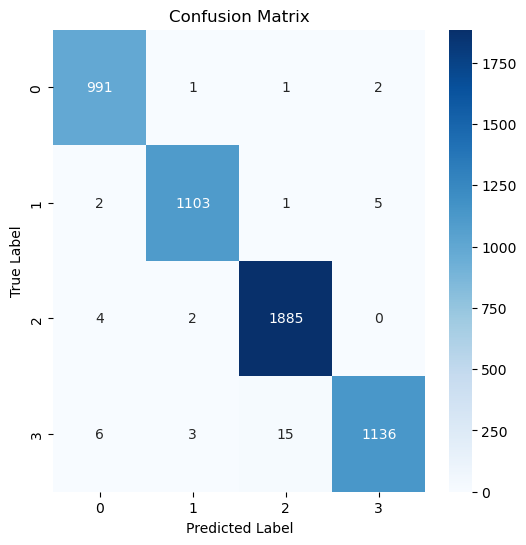

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Membangun model CNN dengan hyperparameter terbaik
best_model = keras.Sequential()
best_model.add(layers.Conv2D(
    filters=64,  # Best Filters
    kernel_size=(5,5),  # Best Kernel Size
    activation='relu',
    input_shape=(64, 64, 3)
))
best_model.add(layers.MaxPooling2D(pool_size=(2,2)))
best_model.add(layers.Flatten())
best_model.add(layers.Dense(
    units=64,  # Best Dense Units
    activation='relu'
))
best_model.add(layers.Dropout(0.3))  # Best Dropout Rate
best_model.add(layers.Dense(4, activation='softmax'))  # 4 kelas untuk HAR

# Compile model
best_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Best Learning Rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history = best_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))


# Evaluasi model
val_loss, val_acc = best_model.evaluate(X_test, y_test)
print(f"Final Model Validation Accuracy: {val_acc:.4f}")
# Summary Model
best_model.summary()


# Prediksi
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

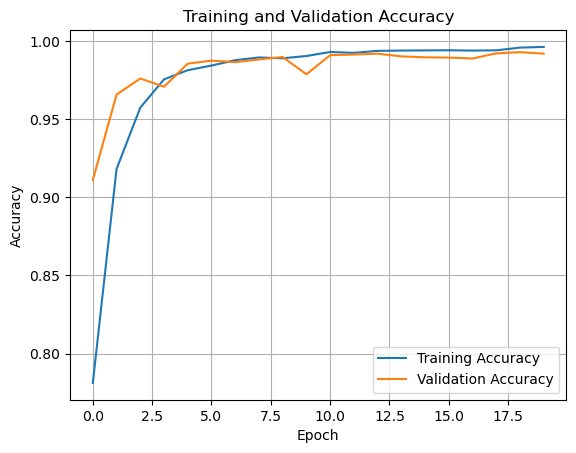

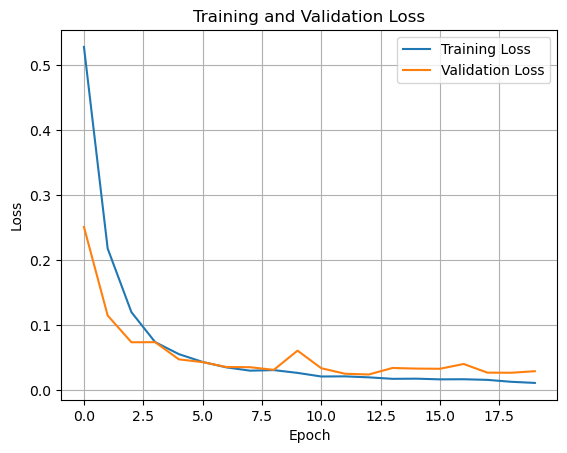

In [11]:
# Plot Akurasi
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
######################### Windowing 30

In [12]:
# Load dataset
X_files, y_files = process_all_datasets("Dataset", snr_min=4.68, snr_max=2621.36, window_size=30)
print("X shape:", X_files.shape)
print("y shape:", y_files.shape)

X shape: (19009, 64, 64, 3)
y shape: (19009,)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_files, y_files, test_size=0.2, random_state=42)
# Tampilkan hasil
print("Total dataset setelah diproses:", len(X_files))
print("Train Files:", len(X_train))
print("Test Files:", len(X_test))
# Cek label unik sebelum dan setelah split
print("Label unik sebelum split:", np.unique(y_files))
print("Label unik di y_train:", np.unique(y_train))
print("Label unik di y_test:", np.unique(y_test))

Total dataset setelah diproses: 19009
Train Files: 15207
Test Files: 3802
Label unik sebelum split: [0 1 2 3]
Label unik di y_train: [0 1 2 3]
Label unik di y_test: [0 1 2 3]


/home/jetson/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.7208 - loss: 0.6421 - val_accuracy: 0.9650 - val_loss: 0.1304
Epoch 2/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9510 - loss: 0.1405 - val_accuracy: 0.9847 - val_loss: 0.0535
Epoch 3/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9814 - loss: 0.0568 - val_accuracy: 0.9940 - val_loss: 0.0320
Epoch 4/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9895 - loss: 0.0341 - val_accuracy: 0.9929 - val_loss: 0.0246
Epoch 5/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9921 - loss: 0.0253 - val_accuracy: 0.9953 - val_loss: 0.0179
Epoch 6/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9927 - loss: 0.0225 - val_accuracy: 0.9966 - val_loss: 0.0128
Epoch 7/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9945 - loss: 0.0152 - val_accuracy: 0.9958 - val_loss: 0.0145
Epoch 8/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9965 - loss: 0.0111 - val_accuracy: 

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 60, 60, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,074,766 (42.25 MB)

 Trainable params: 3,691,588 (14.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,383,178 (28.16 MB)

119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step   
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       556
           1       1.00      1.00      1.00       678
           2       1.00      1.00      1.00      1773
           3       0.99      0.99      0.99       795

    accuracy                           1.00      3802
   macro avg       1.00      1.00      1.00      3802
weighted avg       1.00      1.00      1.00      3802



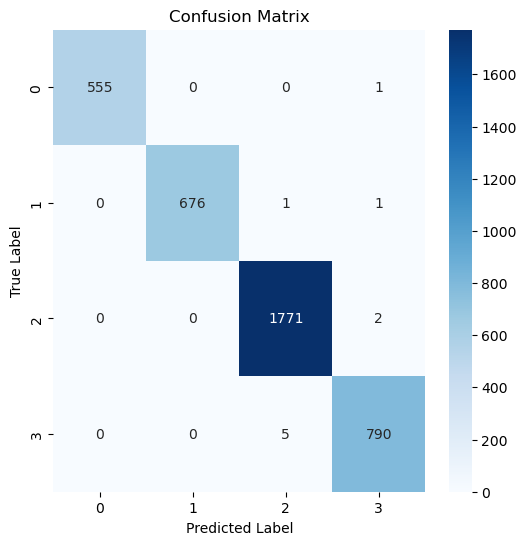

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Membangun model CNN dengan hyperparameter terbaik
best_model = keras.Sequential()
best_model.add(layers.Conv2D(
    filters=64,  # Best Filters
    kernel_size=(5,5),  # Best Kernel Size
    activation='relu',
    input_shape=(64, 64, 3)
))
best_model.add(layers.MaxPooling2D(pool_size=(2,2)))
best_model.add(layers.Flatten())
best_model.add(layers.Dense(
    units=64,  # Best Dense Units
    activation='relu'
))
best_model.add(layers.Dropout(0.3))  # Best Dropout Rate
best_model.add(layers.Dense(4, activation='softmax'))  # 4 kelas untuk HAR

# Compile model
best_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Best Learning Rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history = best_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))



# Evaluasi model
val_loss, val_acc = best_model.evaluate(X_test, y_test)
print(f"Final Model Validation Accuracy: {val_acc:.4f}")
# Summary Model
best_model.summary()


# Prediksi
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

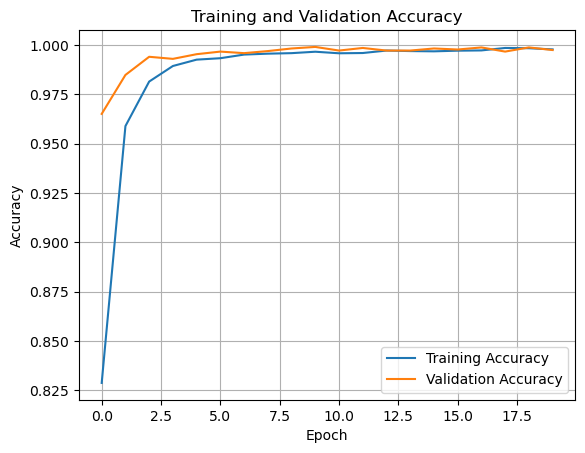

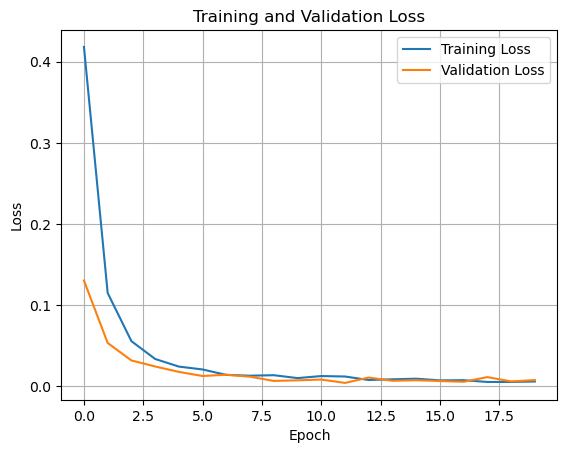

In [15]:
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
best_model.save('andrikun_window30.h5')

In [ ]:
######################### Windowing 40

In [16]:
# Load dataset
X_files, y_files = process_all_datasets("Dataset", snr_min=4.68, snr_max=2621.36, window_size=40)
print("X shape:", X_files.shape)
print("y shape:", y_files.shape)

X shape: (12684, 64, 64, 3)
y shape: (12684,)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_files, y_files, test_size=0.2, random_state=42)
# Tampilkan hasil
print("Total dataset setelah diproses:", len(X_files))
print("Train Files:", len(X_train))
print("Test Files:", len(X_test))
# Cek label unik sebelum dan setelah split
print("Label unik sebelum split:", np.unique(y_files))
print("Label unik di y_train:", np.unique(y_train))
print("Label unik di y_test:", np.unique(y_test))

Total dataset setelah diproses: 12684
Train Files: 10147
Test Files: 2537
Label unik sebelum split: [0 1 2 3]
Label unik di y_train: [0 1 2 3]
Label unik di y_test: [0 1 2 3]


/home/jetson/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
318/318 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.7497 - loss: 0.5974 - val_accuracy: 0.9629 - val_loss: 0.1105
Epoch 2/20
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9573 - loss: 0.1238 - val_accuracy: 0.9890 - val_loss: 0.0542
Epoch 3/20
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9845 - loss: 0.0526 - val_accuracy: 0.9913 - val_loss: 0.0268
Epoch 4/20
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9890 - loss: 0.0333 - val_accuracy: 0.9980 - val_loss: 0.0112
Epoch 5/20
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9917 - loss: 0.0250 - val_accuracy: 0.9988 - val_loss: 0.0075
Epoch 6/20
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9954 - loss: 0.0164 - val_accuracy: 0.9968 - val_loss: 0.0104
Epoch 7/20
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9971 - loss: 0.0103 - val_accuracy: 0.9949 - val_loss: 0.0137
Epoch 8/20
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9969 - loss: 0.0104 - val_accuracy: 

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 60, 60, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,074,766 (42.25 MB)

 Trainable params: 3,691,588 (14.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,383,178 (28.16 MB)

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step   
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       251
           1       1.00      1.00      1.00       309
           2       1.00      1.00      1.00      1522
           3       1.00      1.00      1.00       455

    accuracy                           1.00      2537
   macro avg       1.00      1.00      1.00      2537
weighted avg       1.00      1.00      1.00      2537



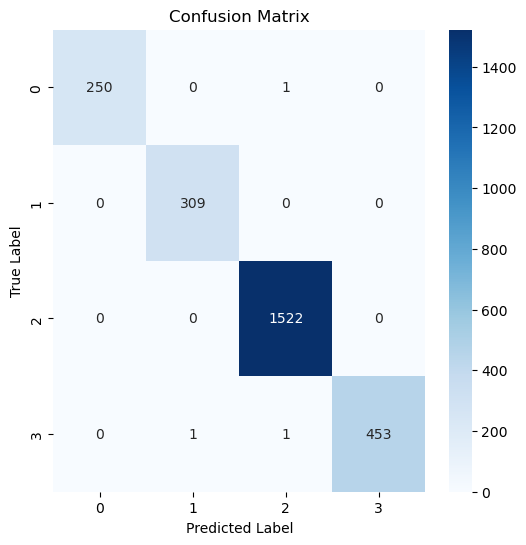

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Membangun model CNN dengan hyperparameter terbaik
best_model = keras.Sequential()
best_model.add(layers.Conv2D(
    filters=64,  # Best Filters
    kernel_size=(5,5),  # Best Kernel Size
    activation='relu',
    input_shape=(64, 64, 3)
))
best_model.add(layers.MaxPooling2D(pool_size=(2,2)))
best_model.add(layers.Flatten())
best_model.add(layers.Dense(
    units=64,  # Best Dense Units
    activation='relu'
))
best_model.add(layers.Dropout(0.3))  # Best Dropout Rate
best_model.add(layers.Dense(4, activation='softmax'))  # 4 kelas untuk HAR

# Compile model
best_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Best Learning Rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history = best_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))



# Evaluasi model
val_loss, val_acc = best_model.evaluate(X_test, y_test)
print(f"Final Model Validation Accuracy: {val_acc:.4f}")
# Summary Model
best_model.summary()


# Prediksi
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

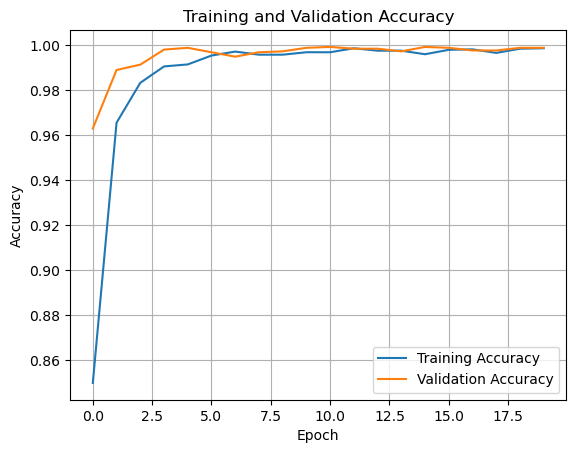

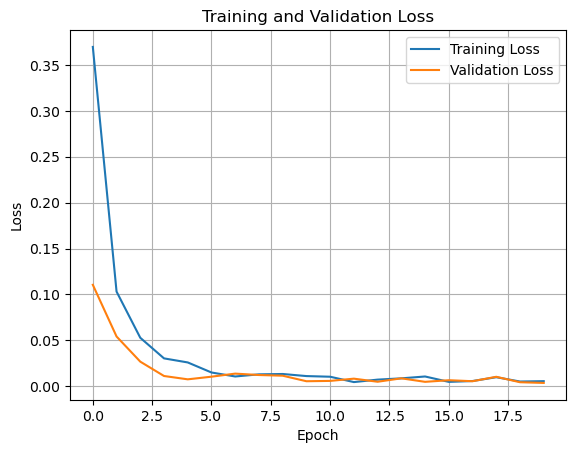

In [19]:
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
best_model.save('andrikun_window40.h5')

In [ ]:
######################### Windowing 50

In [24]:
# Load dataset
X_files, y_files = process_all_datasets("Dataset", snr_min=4.68, snr_max=2621.36, window_size=50)
print("X shape:", X_files.shape)
print("y shape:", y_files.shape)

X shape: (8243, 64, 64, 3)
y shape: (8243,)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_files, y_files, test_size=0.2, random_state=42)
# Tampilkan hasil
print("Total dataset setelah diproses:", len(X_files))
print("Train Files:", len(X_train))
print("Test Files:", len(X_test))
# Cek label unik sebelum dan setelah split
print("Label unik sebelum split:", np.unique(y_files))
print("Label unik di y_train:", np.unique(y_train))
print("Label unik di y_test:", np.unique(y_test))

Total dataset setelah diproses: 8243
Train Files: 6594
Test Files: 1649
Label unik sebelum split: [0 1 2 3]
Label unik di y_train: [0 1 2 3]
Label unik di y_test: [0 1 2 3]


/home/jetson/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.8451 - loss: 0.4227 - val_accuracy: 0.9763 - val_loss: 0.0617
Epoch 2/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9821 - loss: 0.0555 - val_accuracy: 0.9927 - val_loss: 0.0305
Epoch 3/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9861 - loss: 0.0397 - val_accuracy: 0.9976 - val_loss: 0.0126
Epoch 4/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9966 - loss: 0.0134 - val_accuracy: 0.9988 - val_loss: 0.0054
Epoch 5/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9985 - loss: 0.0080 - val_accuracy: 0.9988 - val_loss: 0.0050
Epoch 6/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9982 - loss: 0.0096 - val_accuracy: 0.9994 - val_loss: 0.0032
Epoch 7/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9983 - loss: 0.0067 - val_accuracy: 0.9988 - val_loss: 0.0043
Epoch 8/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9988 - loss: 0.0075 - val_accuracy: 

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,074,766 (42.25 MB)

 Trainable params: 3,691,588 (14.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,383,178 (28.16 MB)

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step   
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      1.00      1.00        79
           2       1.00      1.00      1.00      1337
           3       1.00      1.00      1.00       175

    accuracy                           1.00      1649
   macro avg       1.00      1.00      1.00      1649
weighted avg       1.00      1.00      1.00      1649



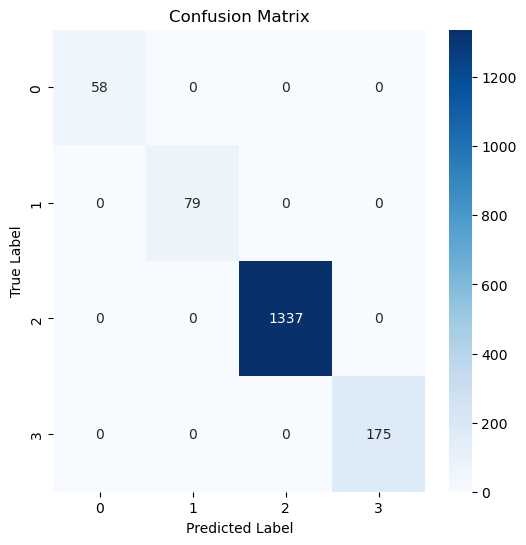

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Membangun model CNN dengan hyperparameter terbaik
best_model = keras.Sequential()
best_model.add(layers.Conv2D(
    filters=64,  # Best Filters
    kernel_size=(5,5),  # Best Kernel Size
    activation='relu',
    input_shape=(64, 64, 3)
))
best_model.add(layers.MaxPooling2D(pool_size=(2,2)))
best_model.add(layers.Flatten())
best_model.add(layers.Dense(
    units=64,  # Best Dense Units
    activation='relu'
))
best_model.add(layers.Dropout(0.3))  # Best Dropout Rate
best_model.add(layers.Dense(4, activation='softmax'))  # 4 kelas untuk HAR

# Compile model
best_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Best Learning Rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
best_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))



# Evaluasi model
val_loss, val_acc = best_model.evaluate(X_test, y_test)
print(f"Final Model Validation Accuracy: {val_acc:.4f}")
# Summary Model
best_model.summary()


# Prediksi
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [27]:
best_model.save('andrikun_window50.h5')

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Membangun model CNN dengan hyperparameter terbaik
best_model = keras.Sequential()
best_model.add(layers.Conv2D(
    filters=64,  # Best Filters
    kernel_size=(5,5),  # Best Kernel Size
    activation='relu',
    input_shape=(64, 64, 3)
))
best_model.add(layers.MaxPooling2D(pool_size=(5,5)))
best_model.add(layers.Flatten())
best_model.add(layers.Dense(
    units=64,  # Best Dense Units
    activation='relu'
))
best_model.add(layers.Dropout(0.3))  # Best Dropout Rate
best_model.add(layers.Dense(4, activation='softmax'))  # 4 kelas untuk HAR

# Compile model
best_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Best Learning Rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
best_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# Evaluasi model
val_loss, val_acc = best_model.evaluate(X_test, y_test)
print(f"Final Model Validation Accuracy: {val_acc:.4f}")
# Summary Model
best_model.summary()


# Prediksi
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [53]:
# Load dataset
X_files, y_files = process_all_datasets("Dataset", snr_min=4.68, snr_max=2621.36, window_size=10)
print("X shape:", X_files.shape)
print("y shape:", y_files.shape)
X_train, X_test, y_train, y_test = train_test_split(X_files, y_files, test_size=0.2, random_state=42)
# Tampilkan hasil
print("Total dataset setelah diproses:", len(X_files))
print("Train Files:", len(X_train))
print("Test Files:", len(X_test))
# Cek label unik sebelum dan setelah split
print("Label unik sebelum split:", np.unique(y_files))
print("Label unik di y_train:", np.unique(y_train))
print("Label unik di y_test:", np.unique(y_test))

/tmp/ipykernel_4577/4228312786.py:95: RuntimeWarning: invalid value encountered in divide
  heatmap_rgb = (heatmap_rgb - heatmap_rgb.min()) / (heatmap_rgb.max() - heatmap_rgb.min())


X shape: (32562, 64, 64, 3)
y shape: (32562,)
Total dataset setelah diproses: 32562
Train Files: 26049
Test Files: 6513
Label unik sebelum split: [0 1 2 3]
Label unik di y_train: [0 1 2 3]
Label unik di y_test: [0 1 2 3]


/home/jetson/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
815/815 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.5048 - loss: nan - val_accuracy: 0.2312 - val_loss: nan
Epoch 2/20
815/815 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.2301 - loss: nan - val_accuracy: 0.2312 - val_loss: nan
Epoch 3/20
815/815 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.2330 - loss: nan - val_accuracy: 0.2312 - val_loss: nan
Epoch 4/20
815/815 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.2325 - loss: nan - val_accuracy: 0.2312 - val_loss: nan
Epoch 5/20
815/815 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.2316 - loss: nan - val_accuracy: 0.2312 - val_loss: nan
Epoch 6/20
815/815 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.2310 - loss: nan - val_accuracy: 0.2312 - val_loss: nan
Epoch 7/20
815/815 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.2311 - loss: nan - val_accuracy: 0.2312 - val_loss: nan
Epoch 8/20
815/815 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.2342 - loss: nan - val_accuracy: 0.2312 - val_loss: nan
Epoch 9/

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 60, 60, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │       921,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,780,366 (10.61 MB)

 Trainable params: 926,788 (3.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,853,578 (7.07 MB)

204/204 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.21      1.00      0.35      1365
           1       0.00      0.00      0.00      1521
           2       0.00      0.00      0.00      2121
           3       0.00      0.00      0.00      1506

    accuracy                           0.21      6513
   macro avg       0.05      0.25      0.09      6513
weighted avg       0.04      0.21      0.07      6513



/home/jetson/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jetson/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jetson/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


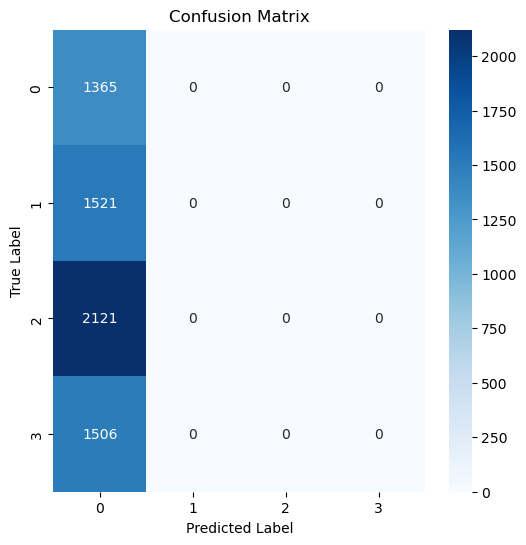

In [54]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Membangun model CNN dengan hyperparameter terbaik
best_model = keras.Sequential()
best_model.add(layers.Conv2D(
    filters=64,  # Best Filters
    kernel_size=(5,5),  # Best Kernel Size
    activation='relu',
    input_shape=(64, 64, 3)
))
best_model.add(layers.MaxPooling2D(pool_size=(4,4)))
best_model.add(layers.Flatten())
best_model.add(layers.Dense(
    units=64,  # Best Dense Units
    activation='relu'
))
best_model.add(layers.Dropout(0.3))  # Best Dropout Rate
best_model.add(layers.Dense(4, activation='softmax'))  # 4 kelas untuk HAR

# Compile model
best_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Best Learning Rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
best_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# Evaluasi model
val_loss, val_acc = best_model.evaluate(X_test, y_test)
print(f"Final Model Validation Accuracy: {val_acc:.4f}")
# Summary Model
best_model.summary()


# Prediksi
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [55]:
# Load dataset
X_files, y_files = process_all_datasets("Dataset", snr_min=4.68, snr_max=2621.36, window_size=40)
print("X shape:", X_files.shape)
print("y shape:", y_files.shape)
X_train, X_test, y_train, y_test = train_test_split(X_files, y_files, test_size=0.2, random_state=42)
# Tampilkan hasil
print("Total dataset setelah diproses:", len(X_files))
print("Train Files:", len(X_train))
print("Test Files:", len(X_test))
# Cek label unik sebelum dan setelah split
print("Label unik sebelum split:", np.unique(y_files))
print("Label unik di y_train:", np.unique(y_train))
print("Label unik di y_test:", np.unique(y_test))

X shape: (12684, 64, 64, 3)
y shape: (12684,)
Total dataset setelah diproses: 12684
Train Files: 10147
Test Files: 2537
Label unik sebelum split: [0 1 2 3]
Label unik di y_train: [0 1 2 3]
Label unik di y_test: [0 1 2 3]


/home/jetson/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
318/318 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.7042 - loss: 0.7208 - val_accuracy: 0.9121 - val_loss: 0.2386
Epoch 2/20
318/318 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9179 - loss: 0.2244 - val_accuracy: 0.9716 - val_loss: 0.0897
Epoch 3/20
318/318 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9624 - loss: 0.1143 - val_accuracy: 0.9842 - val_loss: 0.0506
Epoch 4/20
318/318 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9774 - loss: 0.0677 - val_accuracy: 0.9913 - val_loss: 0.0338
Epoch 5/20
318/318 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9839 - loss: 0.0491 - val_accuracy: 0.9917 - val_loss: 0.0314
Epoch 6/20
318/318 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9900 - loss: 0.0352 - val_accuracy: 0.9819 - val_loss: 0.0491
Epoch 7/20
318/318 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9915 - loss: 0.0277 - val_accuracy: 0.9953 - val_loss: 0.0186
Epoch 8/20
318/318 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9921 - loss: 0.0233 - val_acc

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 60, 60, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │       921,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,780,366 (10.61 MB)

 Trainable params: 926,788 (3.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,853,578 (7.07 MB)

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step  
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       251
           1       1.00      1.00      1.00       309
           2       1.00      1.00      1.00      1522
           3       1.00      0.99      1.00       455

    accuracy                           1.00      2537
   macro avg       1.00      1.00      1.00      2537
weighted avg       1.00      1.00      1.00      2537



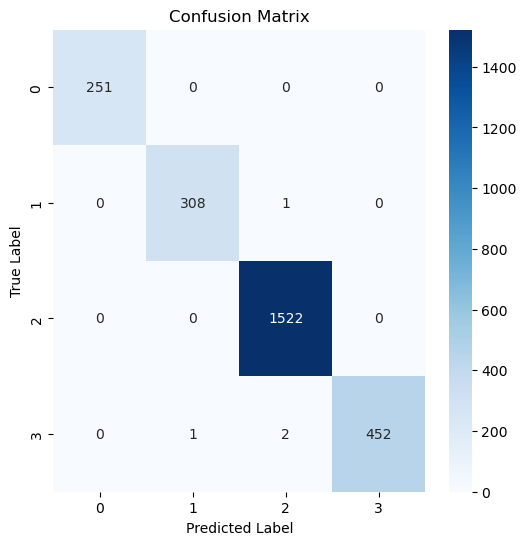

In [56]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Membangun model CNN dengan hyperparameter terbaik
best_model = keras.Sequential()
best_model.add(layers.Conv2D(
    filters=64,  # Best Filters
    kernel_size=(5,5),  # Best Kernel Size
    activation='relu',
    input_shape=(64, 64, 3)
))
best_model.add(layers.MaxPooling2D(pool_size=(4,4)))
best_model.add(layers.Flatten())
best_model.add(layers.Dense(
    units=64,  # Best Dense Units
    activation='relu'
))
best_model.add(layers.Dropout(0.3))  # Best Dropout Rate
best_model.add(layers.Dense(4, activation='softmax'))  # 4 kelas untuk HAR

# Compile model
best_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Best Learning Rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
best_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# Evaluasi model
val_loss, val_acc = best_model.evaluate(X_test, y_test)
print(f"Final Model Validation Accuracy: {val_acc:.4f}")
# Summary Model
best_model.summary()


# Prediksi
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [57]:
# Load dataset
X_files, y_files = process_all_datasets("Dataset", snr_min=4.68, snr_max=2621.36, window_size=50)
print("X shape:", X_files.shape)
print("y shape:", y_files.shape)
X_train, X_test, y_train, y_test = train_test_split(X_files, y_files, test_size=0.2, random_state=42)
# Tampilkan hasil
print("Total dataset setelah diproses:", len(X_files))
print("Train Files:", len(X_train))
print("Test Files:", len(X_test))
# Cek label unik sebelum dan setelah split
print("Label unik sebelum split:", np.unique(y_files))
print("Label unik di y_train:", np.unique(y_train))
print("Label unik di y_test:", np.unique(y_test))

X shape: (8243, 64, 64, 3)
y shape: (8243,)
Total dataset setelah diproses: 8243
Train Files: 6594
Test Files: 1649
Label unik sebelum split: [0 1 2 3]
Label unik di y_train: [0 1 2 3]
Label unik di y_test: [0 1 2 3]


/home/jetson/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8020 - loss: 0.5488 - val_accuracy: 0.9491 - val_loss: 0.1680
Epoch 2/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9386 - loss: 0.1735 - val_accuracy: 0.9794 - val_loss: 0.0803
Epoch 3/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9742 - loss: 0.0800 - val_accuracy: 0.9848 - val_loss: 0.0557
Epoch 4/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9826 - loss: 0.0493 - val_accuracy: 0.9951 - val_loss: 0.0237
Epoch 5/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9909 - loss: 0.0312 - val_accuracy: 0.9958 - val_loss: 0.0194
Epoch 6/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9909 - loss: 0.0287 - val_accuracy: 0.9976 - val_loss: 0.0079
Epoch 7/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9935 - loss: 0.0190 - val_accuracy: 0.9976 - val_loss: 0.0100
Epoch 8/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9845 - loss: 0.0434 - val_acc

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 60, 60, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │       921,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,780,366 (10.61 MB)

 Trainable params: 926,788 (3.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,853,578 (7.07 MB)

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step  
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        58
           1       1.00      1.00      1.00        79
           2       1.00      1.00      1.00      1337
           3       1.00      1.00      1.00       175

    accuracy                           1.00      1649
   macro avg       1.00      1.00      1.00      1649
weighted avg       1.00      1.00      1.00      1649



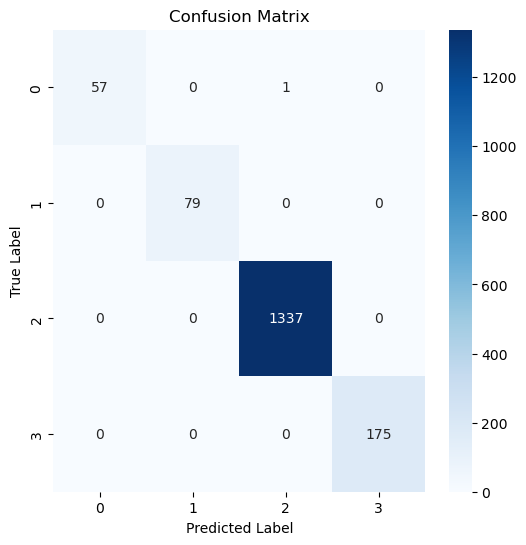

In [58]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Membangun model CNN dengan hyperparameter terbaik
best_model = keras.Sequential()
best_model.add(layers.Conv2D(
    filters=64,  # Best Filters
    kernel_size=(5,5),  # Best Kernel Size
    activation='relu',
    input_shape=(64, 64, 3)
))
best_model.add(layers.MaxPooling2D(pool_size=(4,4)))
best_model.add(layers.Flatten())
best_model.add(layers.Dense(
    units=64,  # Best Dense Units
    activation='relu'
))
best_model.add(layers.Dropout(0.3))  # Best Dropout Rate
best_model.add(layers.Dense(4, activation='softmax'))  # 4 kelas untuk HAR

# Compile model
best_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Best Learning Rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
best_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# Evaluasi model
val_loss, val_acc = best_model.evaluate(X_test, y_test)
print(f"Final Model Validation Accuracy: {val_acc:.4f}")
# Summary Model
best_model.summary()


# Prediksi
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [3]:
# Load dataset
X_files, y_files = process_all_datasets("Dataset", snr_min=4.68, snr_max=2621.36, window_size=20)
print("X shape:", X_files.shape)
print("y shape:", y_files.shape)
X_train, X_test, y_train, y_test = train_test_split(X_files, y_files, test_size=0.2, random_state=42)
# Tampilkan hasil
print("Total dataset setelah diproses:", len(X_files))
print("Train Files:", len(X_train))
print("Test Files:", len(X_test))
# Cek label unik sebelum dan setelah split
print("Label unik sebelum split:", np.unique(y_files))
print("Label unik di y_train:", np.unique(y_train))
print("Label unik di y_test:", np.unique(y_test))

X shape: (25782, 64, 64, 3)
y shape: (25782,)
Total dataset setelah diproses: 25782
Train Files: 20625
Test Files: 5157
Label unik sebelum split: [0 1 2 3]
Label unik di y_train: [0 1 2 3]
Label unik di y_test: [0 1 2 3]


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Membangun model CNN dengan hyperparameter terbaik
best_model = keras.Sequential()
best_model.add(layers.Conv2D(
    filters=64,  # Best Filters
    kernel_size=(5,5),  # Best Kernel Size
    activation='relu',
    input_shape=(64, 64, 3)
))
best_model.add(layers.MaxPooling2D(pool_size=(4,4)))
best_model.add(layers.Flatten())
best_model.add(layers.Dense(
    units=64,  # Best Dense Units
    activation='relu'
))
best_model.add(layers.Dropout(0.3))  # Best Dropout Rate
best_model.add(layers.Dense(4, activation='softmax'))  # 4 kelas untuk HAR

# Compile model
best_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Best Learning Rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
best_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# Evaluasi model
val_loss, val_acc = best_model.evaluate(X_test, y_test)
print(f"Final Model Validation Accuracy: {val_acc:.4f}")


/home/jetson/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


I0000 00:00:1742620427.011371    4762 service.cc:145] XLA service 0xfffcb80049d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742620427.011601    4762 service.cc:153]   StreamExecutor device (0): Orin, Compute Capability 8.7


  7/645 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.3510 - loss: 1.3814  

I0000 00:00:1742620432.670150    4762 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


645/645 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.6266 - loss: 0.8378 - val_accuracy: 0.8829 - val_loss: 0.3459
Epoch 2/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8668 - loss: 0.3442 - val_accuracy: 0.9327 - val_loss: 0.1959
Epoch 3/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9209 - loss: 0.2126 - val_accuracy: 0.9490 - val_loss: 0.1450
Epoch 4/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9482 - loss: 0.1435 - val_accuracy: 0.9608 - val_loss: 0.1137
Epoch 5/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9631 - loss: 0.1060 - val_accuracy: 0.9717 - val_loss: 0.0807
Epoch 6/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9736 - loss: 0.0801 - val_accuracy: 0.9734 - val_loss: 0.0728
Epoch 7/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9811 - loss: 0.0557 - val_accuracy: 0.9794 - val_loss: 0.0609
Epoch 8/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9823 - loss: 0.0519 - val_accurac

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 60, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       921,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,780,366 (10.61 MB)

 Trainable params: 926,788 (3.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,853,578 (7.07 MB)

162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       995
           1       0.97      1.00      0.98      1111
           2       0.99      0.99      0.99      1891
           3       0.99      0.97      0.98      1160

    accuracy                           0.99      5157
   macro avg       0.98      0.99      0.99      5157
weighted avg       0.99      0.99      0.99      5157



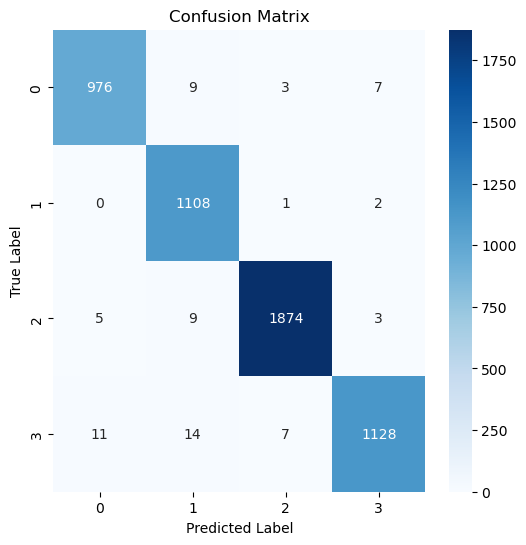

In [5]:
# Summary Model
best_model.summary()


# Prediksi
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()